In [1]:
#import libraries 
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
from numpy.linalg import norm
import scipy as sp
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from nltk import bigrams
import itertools
import torch


/home/suyash/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
#load the sentences from the file sentences.json
with open('sentences.json') as f:
    saved_sentences = json.load(f)



In [4]:
print(len(saved_sentences))
# print(saved_sentences[1000:1531])

80000


In [5]:
# tokens = []
# for i in range(len(saved_sentences)):
#         #remove punctuations and special characters
#         sentence = saved_sentences[i]
#         sentence = re.sub(r'[^\w<>]', ' ', sentence)
#         sentence = re.sub(r'\s+', ' ', sentence.strip())        
#         saved_sentences[i] = sentence
#         words = sentence.split()
#         #remove empty words
#         words = [word for word in words if word != '']
#         tokens.append(words)

# # tokenisATION using nltk 
# tokens = [word_tokenize(sentence) for sentence in saved_sentences]
    


In [6]:
saved_sentences[0]
tokens = saved_sentences

In [7]:

#claculate the frequency of each word
word_freq = {}
for i in range(len(tokens)):
        for word in tokens[i]:
                if word not in word_freq:
                        word_freq[word] = 1
                else:
                        word_freq[word] += 1   



KeyboardInterrupt: 

In [ ]:
#remove words that has word frequency less than 5 from tokens
frequent_tokens = []
for i in range(len(tokens)):
        frequent_tokens.append([word for word in tokens[i] if word_freq[word] > 4])
        


In [ ]:
# len(tokens)
len(frequent_tokens)


80000

In [ ]:
tokens = frequent_tokens

In [ ]:
vocab = list(set([word for sentence in tokens for word in sentence]))
vocab_size = len(vocab)
word2idx = {word:idx for idx, word in enumerate(vocab)}
idx2word = {idx:word for idx, word in enumerate(vocab)}
# co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
#define co_matrix as scapy sparse matrix


In [ ]:
# producea co-occurence matrix
def co_occurence_matrix(tokens, window_size):
        co_matrix = sp.sparse.lil_matrix((vocab_size, vocab_size))
        for sentence in tokens:
                indices = [word2idx[word] for word in sentence]
                for center_word_pos in range(len(indices)):
                        for w in range(-window_size, window_size + 1):
                                context_word_pos = center_word_pos + w
                                if context_word_pos < 0 or context_word_pos >= len(indices) or center_word_pos == context_word_pos:
                                        continue
                                context_word_idx = indices[context_word_pos]
                                co_matrix[indices[center_word_pos], context_word_idx] += 1
                                # co_matrix[context_word_idx,indices[center_word_pos]] += 1

        return co_matrix



In [ ]:
co_matrix = co_occurence_matrix(tokens, 4)

In [ ]:
co_matrix.shape

(42251, 42251)

In [ ]:
#convert co_matrix to a sparse matrix
co_matrix = sp.sparse.lil_matrix(co_matrix)
co_matrix = co_matrix.astype(float)

#perform singular value decomposition using spacy
u, s, v = sp.sparse.linalg.svds(co_matrix , k=100)




In [ ]:

co_matrix

<42251x42251 sparse matrix of type '<class 'numpy.float64'>'
	with 16171961 stored elements in List of Lists format>

In [ ]:
# save co_matrix in a text file
# np.savetxt('co_matrix.txt', co_matrix.toarray(), fmt='%d')
u

array([[-3.33102355e-03, -1.07526751e-02,  1.41933776e-04, ...,
         9.11707956e-04, -7.00067644e-04,  1.68084540e-03],
       [-3.53439649e-04, -2.16270371e-04, -1.88301503e-04, ...,
         6.61553931e-05, -1.47010704e-04,  5.63684990e-05],
       [-1.96831288e-06,  3.43386535e-03,  2.42054036e-03, ...,
        -5.95344280e-04,  2.05924766e-04,  2.59862614e-03],
       ...,
       [-2.67561678e-05,  5.08023529e-05, -1.73230654e-05, ...,
         3.36055269e-05, -1.52430176e-05,  7.42771430e-06],
       [-3.21161509e-03,  5.49023236e-04, -1.09656549e-04, ...,
         1.41684737e-04,  1.24288654e-05,  1.35481988e-04],
       [ 2.14164389e-04, -2.05468538e-04,  1.38186158e-04, ...,
         6.02399556e-07, -6.54042299e-07,  6.82170132e-06]])

In [ ]:
dimension = 0
cutoff_sv = 0.5
denominator = sum(s)
cont_sum = 0
for i, x in enumerate(s):
    cont_sum += x
    if (cont_sum/denominator > cutoff_sv):
        dimension = i+1
        break
vectors = u[:, :dimension]
vectors = [v/norm(v) for v in vectors]


# with open("svd_vectors.txt", "w") as f:
#     for word, vector in zip(vocab, vectors):
#         f.write(word + '\n')
#         f.write(str(vector) + '\n')


In [ ]:
f = open("svd_vectors.txt", "w")
for word, vector in zip(vocab, vectors):
        f.write(word)
        f.write('\n')
        p = str(vector).replace('\n', '')
        f.write(p)
        f.write('\n')
f.close()

dimension

NameError: name 'vectors' is not defined

In [ ]:
def get_top_tenn(word):
    vec_words = []
    line1, line2 = (1, 1)
    vector=[]
    with open("svd_vectors.txt", "r") as f:
        for line1 in f:
            line1 = line1[:-1]
            line2 = f.readline()
            line2 = re.sub(r' +', ',', line2).replace('[,', '[')
            try:
                line2 = eval(line2)
                # print("word", line1, "vector", line2)
                vec_words += [(line1, line2)]
                if (line1 == word):
                    vector = line2
            except:
            #   print("error")
              f.readline()

    dist={}
    # print(vector)
    for vec_word in vec_words:
        if(vec_word[0] == word):
            
            continue
        try:
            dist[vec_word[0]] = np.dot(vector, vec_word[1])
        except:
            # print("error")
            pass
    sort_v = sorted(dist.items(), key=lambda x: x[1], reverse=True)
    #print only top ten words 
    return sort_v[:10] , vector
    # for i in range(10):
    #     print(sort_v[i])

In [ ]:
# get_top_ten("boy")
import re
sort_v = get_top_tenn("hot")

print(sort_v)
#write the top ten words of titanic in a text file


[('airport', 0.6220800575735579), ('hotel', 0.6103867692460627), ('subway', 0.6091758090120347), ('club', 0.5900541439004647), ('beach', 0.5862951160648496), ('rape', 0.5808772830460175), ('shoots', 0.5681871587987919), ('riding', 0.5669181403315937), ('stealing', 0.564514844831618), ('buffed', 0.5598534810377234)]


In [ ]:
words =["child","charming", "win","excellent","car"]

In [ ]:
vector_child = []
vector_charming = []
vector_win = []
vector_excellent = []
vector_car = []


ten_child = []
ten_charming = []
ten_win = []
ten_excellent = []
ten_car = []

ten_child = get_top_tenn("Child")
ten_charming = get_top_tenn("charming")
# ten_win = get_top_tenn("win")
# ten_excellent = get_top_tenn("excellent")
# ten_car = get_top_tenn("car")

ten_child


[]

In [ ]:
f = open("top_ten_words.txt", "w")
f.write("child")
f.write('\n')
for i in range(10):
    f.write(str(ten_child[i]))
    f.write('\n')
f.write("charming")
f.write('\n')
for i in range(10):
    f.write(str(ten_charming[i]))
    f.write('\n')
f.write("win")
f.write('\n')
for i in range(10):
    f.write(str(ten_win[i]))
    f.write('\n')
f.write("excellent")
f.write('\n')
for i in range(10):
    f.write(str(ten_excellent[i]))
    f.write('\n')
f.write("car")
f.write('\n')
for i in range(10):
    f.write(str(ten_car[i]))
    f.write('\n')
f.close()


IndexError: list index out of range

In [ ]:
# #show  a table of sno. ten_child[0] ,ten_child[1]
# child_table = pd.DataFrame(ten_child, columns = ['word', 'Cosine similarity'])
# child_table

# charming_table = pd.DataFrame(ten_charming, columns = ['word', 'Cosine similarity'])
# charming_table

# win_table = pd.DataFrame(ten_win, columns = ['word', 'Cosine similarity'])
# win_table

# excellent_table = pd.DataFrame(ten_excellent, columns = ['word', 'Cosine similarity'])
# excellent_table

# car_table = pd.DataFrame(ten_car, columns = ['word', 'Cosine similarity'])
# car_table

,word,Cosine similarity
0,truck,0.736210
1,hotel,0.726858
2,gas,0.714591
3,door,0.711838
4,boat,0.703883
5,bar,0.699623
6,driving,0.689875
7,gun,0.688375
8,crash,0.686675
9,train,0.679839


In [ ]:
word2idx[ten_child[0][0]]

22634

In [ ]:
for i in range(10):
    vector_child.append(vectors[word2idx[ten_child[i][0]]])
    vector_charming.append(vectors[word2idx[ten_charming[i][0]]])
    vector_win.append(vectors[word2idx[ten_win[i][0]]])
    vector_excellent.append(vectors[word2idx[ten_excellent[i][0]]])
    vector_car.append(vectors[word2idx[ten_car[i][0]]])
    


In [ ]:
#compress the vectors to 2 dimensions 
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
pca.fit(vector_child)
vector_child = pca.transform(vector_child)
pca.fit(vector_charming)
vector_charming = pca.transform(vector_charming)
pca.fit(vector_win)
vector_win = pca.transform(vector_win)
pca.fit(vector_excellent)
vector_excellent = pca.transform(vector_excellent)
pca.fit(vector_car)
vector_car = pca.transform(vector_car)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


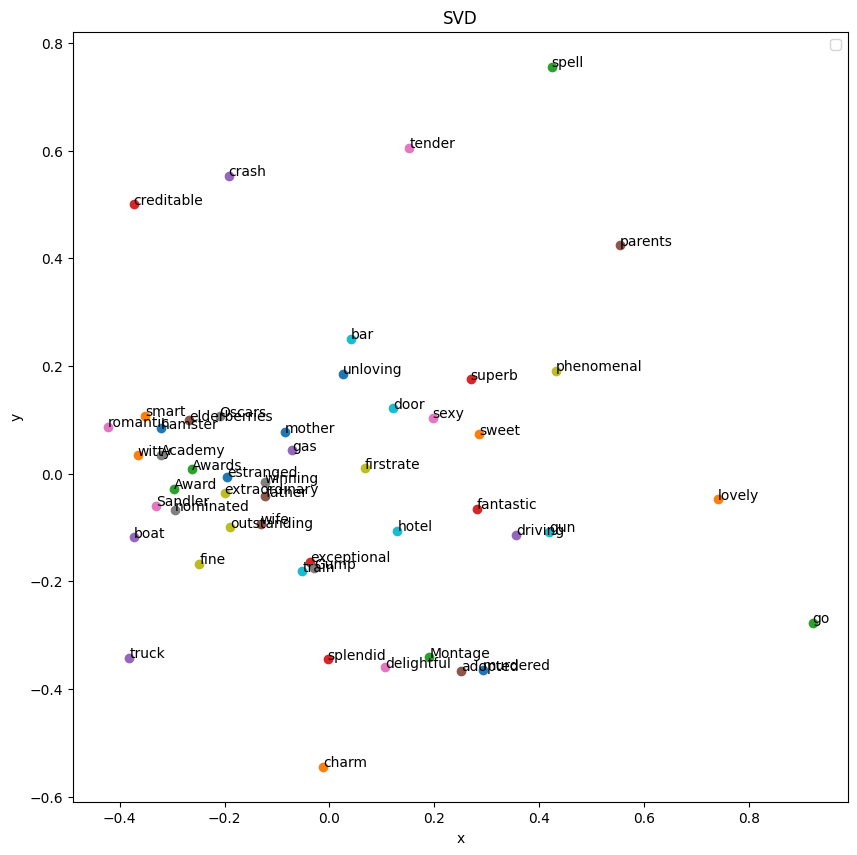

In [ ]:
#plot the vectors in a 2D graph also write the text below each point
#show the color coding for each color
plt.figure(figsize=(10,10))

for i in range(10):
    plt.scatter(vector_child[i,0], vector_child[i,1] )
    plt.annotate(ten_child[i][0], (vector_child[i,0], vector_child[i,1]))
    plt.scatter(vector_charming[i,0], vector_charming[i,1] )
    plt.annotate(ten_charming[i][0], (vector_charming[i,0], vector_charming[i,1]) )
    plt.scatter(vector_win[i,0], vector_win[i,1] )
    plt.annotate(ten_win[i][0], (vector_win[i,0], vector_win[i,1]) )
    plt.scatter(vector_excellent[i,0], vector_excellent[i,1] )
    plt.annotate(ten_excellent[i][0], (vector_excellent[i,0], vector_excellent[i,1]) )
    plt.scatter(vector_car[i,0], vector_car[i,1] )
    plt.annotate(ten_car[i][0], (vector_car[i,0], vector_car[i,1])  )

#plot labels and legend like exellent is red, child is blue etc


plt.xlabel('x')
plt.ylabel('y')
plt.title('SVD')
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


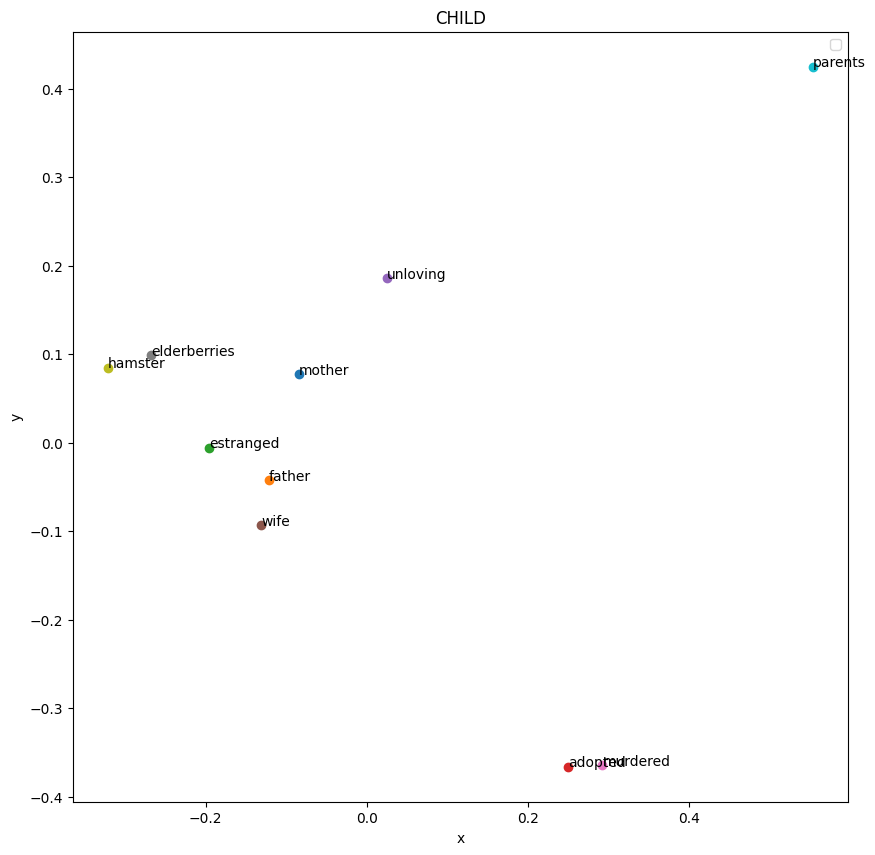

In [ ]:
plt.figure(figsize=(10,10))

for i in range(10):
    plt.scatter(vector_child[i,0], vector_child[i,1] )
    plt.annotate(ten_child[i][0], (vector_child[i,0], vector_child[i,1]))
    # plt.scatter(vector_charming[i,0], vector_charming[i,1] )
    # plt.annotate(ten_charming[i][0], (vector_charming[i,0], vector_charming[i,1]) )
    # plt.scatter(vector_win[i,0], vector_win[i,1] )
    # plt.annotate(ten_win[i][0], (vector_win[i,0], vector_win[i,1]) )
    # plt.scatter(vector_excellent[i,0], vector_excellent[i,1] )
    # plt.annotate(ten_excellent[i][0], (vector_excellent[i,0], vector_excellent[i,1]) )
    # plt.scatter(vector_car[i,0], vector_car[i,1] )
    # plt.annotate(ten_car[i][0], (vector_car[i,0], vector_car[i,1])  )

#plot labels and legend like exellent is red, child is blue etc


plt.xlabel('x')
plt.ylabel('y')
plt.title('CHILD')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


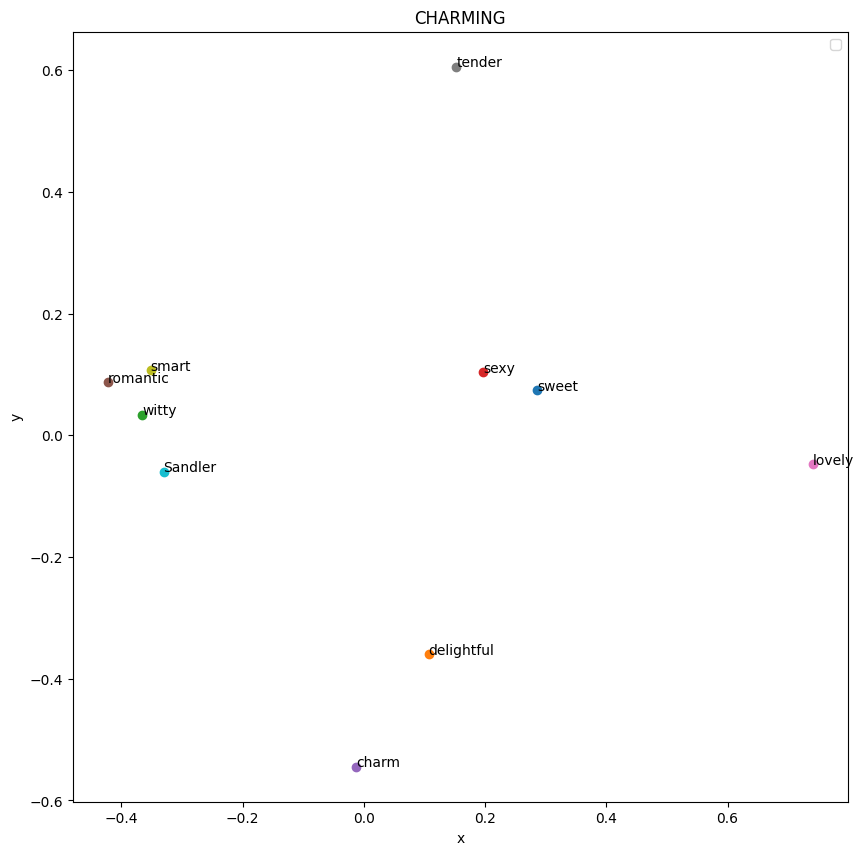

In [ ]:
plt.figure(figsize=(10,10))

for i in range(10):
    # plt.scatter(vector_child[i,0], vector_child[i,1] )
    # plt.annotate(ten_child[i][0], (vector_child[i,0], vector_child[i,1]))
    plt.scatter(vector_charming[i,0], vector_charming[i,1] )
    plt.annotate(ten_charming[i][0], (vector_charming[i,0], vector_charming[i,1]) )
    # plt.scatter(vector_win[i,0], vector_win[i,1] )
    # plt.annotate(ten_win[i][0], (vector_win[i,0], vector_win[i,1]) )
    # plt.scatter(vector_excellent[i,0], vector_excellent[i,1] )
    # plt.annotate(ten_excellent[i][0], (vector_excellent[i,0], vector_excellent[i,1]) )
    # plt.scatter(vector_car[i,0], vector_car[i,1] )
    # plt.annotate(ten_car[i][0], (vector_car[i,0], vector_car[i,1])  )

#plot labels and legend like exellent is red, child is blue etc


plt.xlabel('x')
plt.ylabel('y')
plt.title('CHARMING')
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


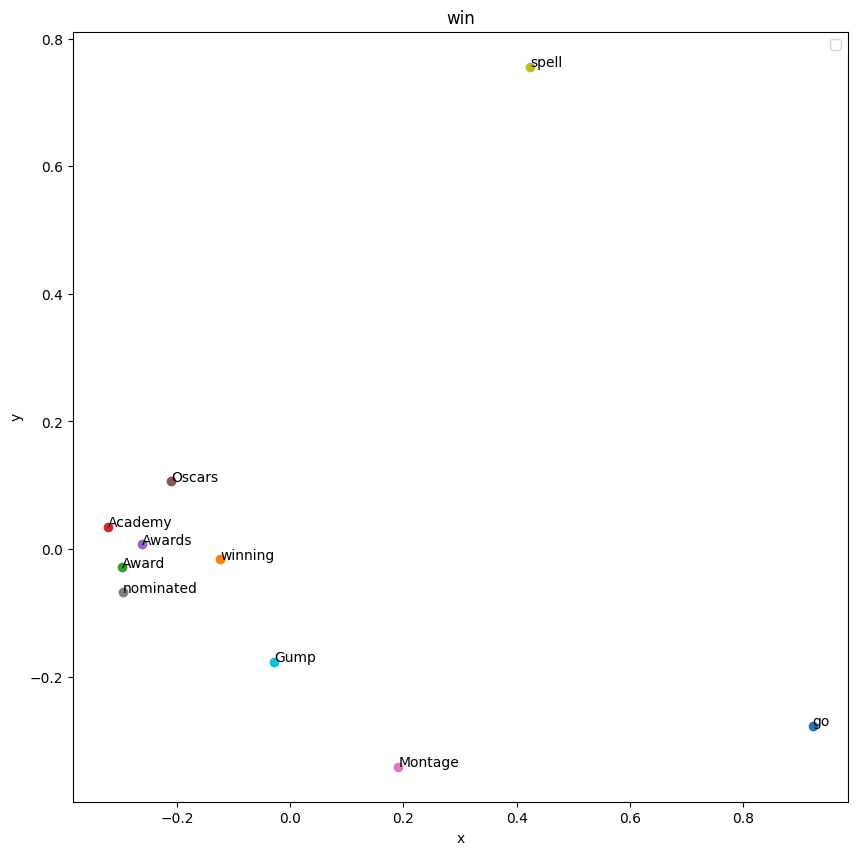

In [ ]:
plt.figure(figsize=(10,10))

for i in range(10):
    # plt.scatter(vector_child[i,0], vector_child[i,1] )
    # plt.annotate(ten_child[i][0], (vector_child[i,0], vector_child[i,1]))
    # plt.scatter(vector_charming[i,0], vector_charming[i,1] )
    # plt.annotate(ten_charming[i][0], (vector_charming[i,0], vector_charming[i,1]) )
    plt.scatter(vector_win[i,0], vector_win[i,1] )
    plt.annotate(ten_win[i][0], (vector_win[i,0], vector_win[i,1]) )
    # plt.scatter(vector_excellent[i,0], vector_excellent[i,1] )
    # plt.annotate(ten_excellent[i][0], (vector_excellent[i,0], vector_excellent[i,1]) )
    # plt.scatter(vector_car[i,0], vector_car[i,1] )
    # plt.annotate(ten_car[i][0], (vector_car[i,0], vector_car[i,1])  )

#plot labels and legend like exellent is red, child is blue etc


plt.xlabel('x')
plt.ylabel('y')
plt.title('win')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


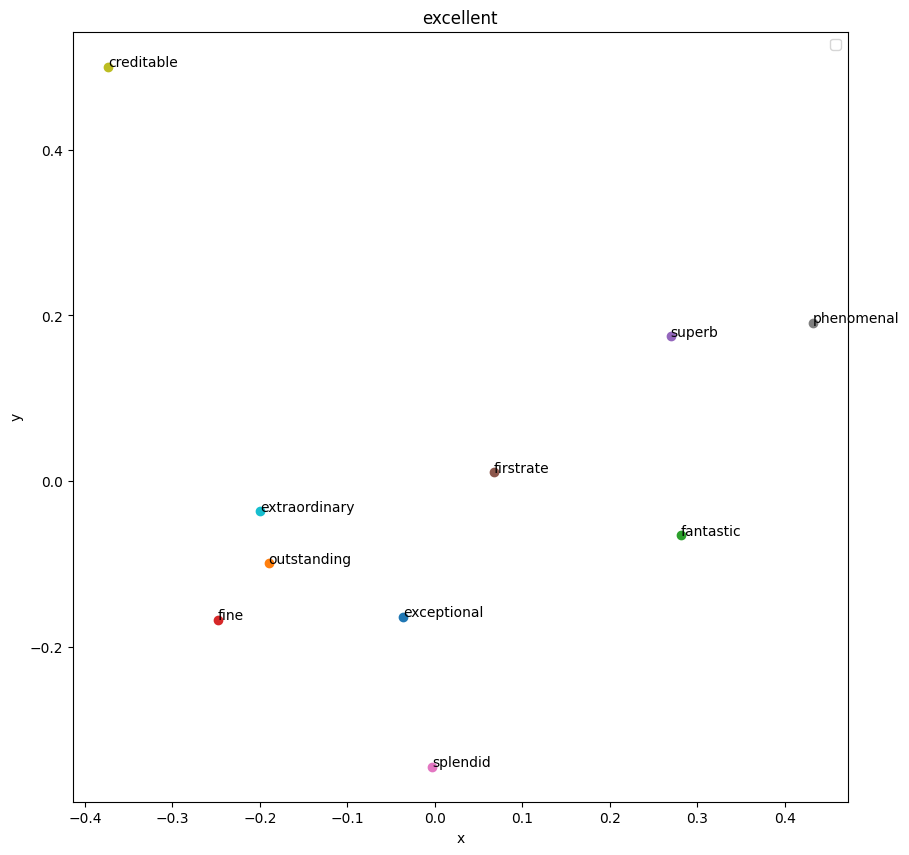

In [ ]:
plt.figure(figsize=(10,10))

for i in range(10):
    # plt.scatter(vector_child[i,0], vector_child[i,1] )
    # plt.annotate(ten_child[i][0], (vector_child[i,0], vector_child[i,1]))
    # plt.scatter(vector_charming[i,0], vector_charming[i,1] )
    # plt.annotate(ten_charming[i][0], (vector_charming[i,0], vector_charming[i,1]) )
    # plt.scatter(vector_win[i,0], vector_win[i,1] )
    # plt.annotate(ten_win[i][0], (vector_win[i,0], vector_win[i,1]) )
    plt.scatter(vector_excellent[i,0], vector_excellent[i,1] )
    plt.annotate(ten_excellent[i][0], (vector_excellent[i,0], vector_excellent[i,1]) )
    # plt.scatter(vector_car[i,0], vector_car[i,1] )
    # plt.annotate(ten_car[i][0], (vector_car[i,0], vector_car[i,1])  )

#plot labels and legend like exellent is red, child is blue etc


plt.xlabel('x')
plt.ylabel('y')
plt.title('excellent')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


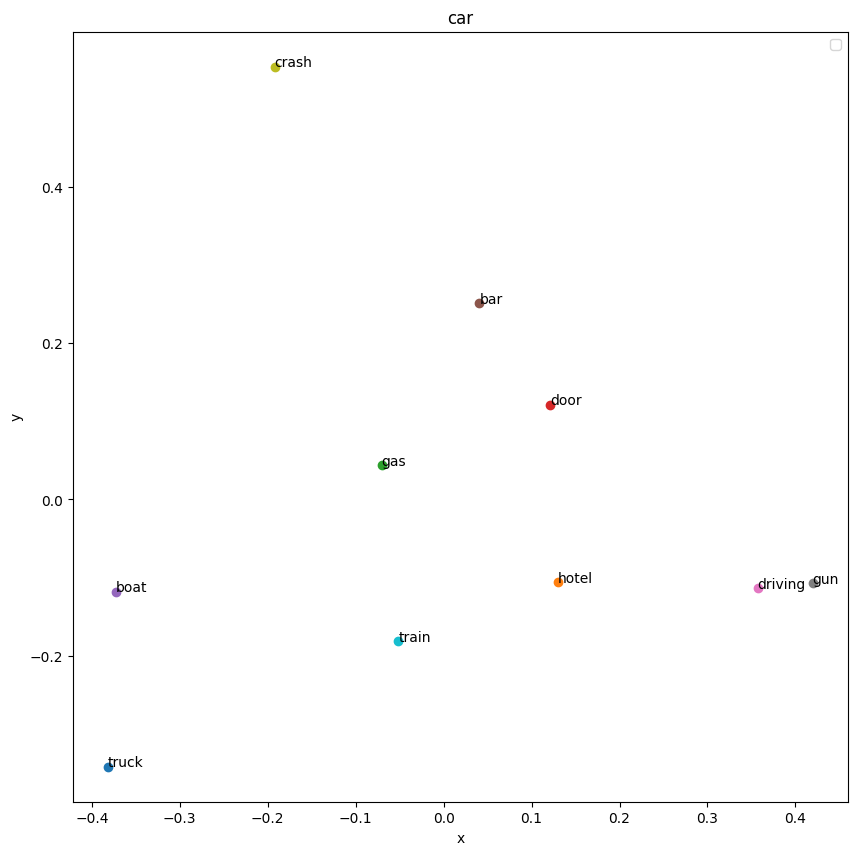

In [ ]:
plt.figure(figsize=(10,10))

for i in range(10):
    # plt.scatter(vector_child[i,0], vector_child[i,1] )
    # plt.annotate(ten_child[i][0], (vector_child[i,0], vector_child[i,1]))
    # plt.scatter(vector_charming[i,0], vector_charming[i,1] )
    # plt.annotate(ten_charming[i][0], (vector_charming[i,0], vector_charming[i,1]) )
    # plt.scatter(vector_win[i,0], vector_win[i,1] )
    # plt.annotate(ten_win[i][0], (vector_win[i,0], vector_win[i,1]) )
    # plt.scatter(vector_excellent[i,0], vector_excellent[i,1] )
    # plt.annotate(ten_excellent[i][0], (vector_excellent[i,0], vector_excellent[i,1]) )
    plt.scatter(vector_car[i,0], vector_car[i,1] )
    plt.annotate(ten_car[i][0], (vector_car[i,0], vector_car[i,1])  )

#plot labels and legend like exellent is red, child is blue etc


plt.xlabel('x')
plt.ylabel('y')
plt.title('car')
plt.legend()
plt.show()

In [ ]:
#10 most similar words to titanic

# k= get_top_tenn("Titanic")
# print(k)





[('1997', 0.5346438161688873), ('Alistair', 0.501209718445784), ('Cameron', 0.4960957154603256), ('AlMukhtar', 0.49460000398286963), ('K', 0.49296768192262047), ('de', 0.49024583691592954), ('sinking', 0.48965743884790175), ('Peltier', 0.4783270557282178), ('1912', 0.4774421497787661), ('disaster', 0.47492197916406786)]
        word  Cosine similarity
0       1997           0.534644
1   Alistair           0.501210
2    Cameron           0.496096
3  AlMukhtar           0.494600
4          K           0.492968
5         de           0.490246
6    sinking           0.489657
7    Peltier           0.478327
8       1912           0.477442
9   disaster           0.474922


In [ ]:
ten_Titanic = []
vector_Titanic = []

ten_Titanic = get_top_tenn("Titanic")

In [ ]:
a =[]
b = []
a ,v= get_top_tenn("hot")

In [ ]:
table = pd.DataFrame(b, columns=['word' , 'Cosine similarity'])

for i in range(10):
    b.append(vectors[word2idx[a[i][0]]])

c = PCA(n_components=2)
b= c.fit_transform(c)

NameError: name 'vectors' is not defined

In [ ]:
titanic_table = pd.DataFrame(ten_Titanic, columns=['word' , 'Cosine similarity'])
titanic_table

for i in range(10):
    vector_Titanic.append(vectors[word2idx[ten_Titanic[i][0]]])


# conpress the vectors to 2D
pca = PCA(n_components=2)
vector_Titanic = pca.fit_transform(vector_Titanic)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


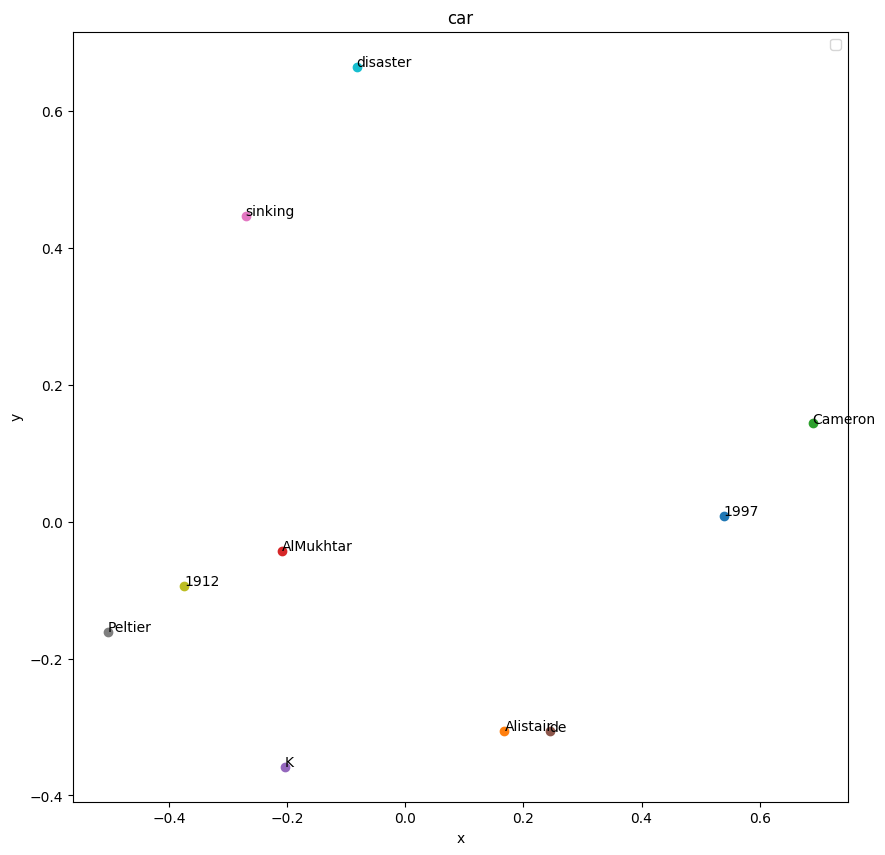

In [ ]:
plt.figure(figsize=(10,10))

for i in range(10):
    # plt.scatter(vector_child[i,0], vector_child[i,1] )
    # plt.annotate(ten_child[i][0], (vector_child[i,0], vector_child[i,1]))
    # plt.scatter(vector_charming[i,0], vector_charming[i,1] )
    # plt.annotate(ten_charming[i][0], (vector_charming[i,0], vector_charming[i,1]) )
    # plt.scatter(vector_win[i,0], vector_win[i,1] )
    # plt.annotate(ten_win[i][0], (vector_win[i,0], vector_win[i,1]) )
    # plt.scatter(vector_excellent[i,0], vector_excellent[i,1] )
    # plt.annotate(ten_excellent[i][0], (vector_excellent[i,0], vector_excellent[i,1]) )
    # plt.scatter(vector_car[i,0], vector_car[i,1] )
    # plt.annotate(ten_car[i][0], (vector_car[i,0], vector_car[i,1])  )

    plt.scatter(vector_Titanic[i,0], vector_Titanic[i,1] )
    plt.annotate(ten_Titanic[i][0], (vector_Titanic[i,0], vector_Titanic[i,1])  )
#plot labels and legend like exellent is red, child is blue etc


plt.xlabel('x')
plt.ylabel('y')
plt.title('car')
plt.legend()
plt.show()